# Voltage-Clamp Ramp Membrane Test

This project analyzes an membrane test sweeps generated by LTSpice from a circuit modeling a voltage-clamped neuron.

See the full website: **https://swharden.com/blog/2020-10-11-model-neuron-ltspice/**

![](../models/single-electrode-memtest/ramp-simulation.png)

## Environment Setup

In [1]:
import os
import ltspice
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import scipy.optimize
np.set_printoptions(suppress=True)

HERE = os.path.abspath(os.getcwd())
simFilePath = os.path.abspath(f"{HERE}/../models/single-electrode-memtest/memtest2.raw")
assert os.path.isfile(simFilePath)

## Load Simualtion Data

In [2]:
# read data from the LTSpice .raw file
l = ltspice.Ltspice(simFilePath)
l.parse()

# obtain data by its identifier and scale it as desired
times = l.getTime() * 1e3 # ms
Vcell = l.getData('V(vm)') * 1e3  # mV
Vcommand = l.getData('V(vc)') * 1e3  # mV
Iclamp = l.getData('I(Rf)') * 1e12  # pA

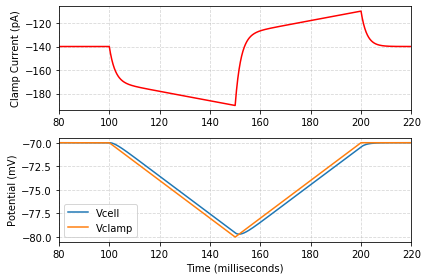

In [3]:
# plot scaled simulation data
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.grid(ls='--', alpha=.5)
plt.plot(times, Iclamp, 'r-')
plt.ylabel("Clamp Current (pA)")

plt.subplot(212, sharex=ax1)
plt.grid(ls='--', alpha=.5)
plt.plot(times, Vcell, label="Vcell")
plt.plot(times, Vcommand, label="Vclamp")
plt.ylabel("Potential (mV)")
plt.xlabel("Time (milliseconds)")
plt.legend()

plt.axis([80, 220, None, None])
plt.tight_layout()
plt.savefig("mtramp1.png")
plt.show()

In [4]:
# interpolate data for 20 kHz sample rate
timesOriginal = np.array(times)
f = scipy.interpolate.interp1d(timesOriginal, Iclamp)
pointCount = int((timesOriginal[-1] - timesOriginal[0]) * 20) + 1
times = np.linspace(timesOriginal[0], timesOriginal[-1], pointCount)
Iclamp = f(times)

Isolate the downward and upward slopes

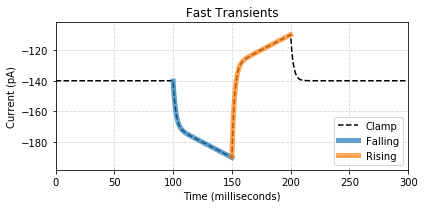

In [5]:
signalFalling = Iclamp[2000:3000]
signalRising = Iclamp[3000:4000]
assert len(signalFalling)==len(signalRising)

timeFalling = np.arange(len(signalFalling))/20+100
timeRising = np.arange(len(signalRising))/20+150

plt.figure(figsize=(6, 3))
plt.grid(ls='--', alpha=.5)
plt.title("Fast Transients")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Current (pA)")
plt.plot(times, Iclamp, 'k--', label="Clamp")
plt.plot(timeFalling, signalFalling, 'C0', lw=5, alpha=.7, label="Falling")
plt.plot(timeRising, signalRising, 'C1', lw=5, alpha=.7, label="Rising")
plt.legend(loc=4)
plt.margins(0, .1)
plt.tight_layout()
plt.savefig("mtramp2.png")
plt.show()

In [8]:
signalFallingRev = signalFalling[::-1]
overlayedTimes = np.arange(len(signalFalling))/20

steadyFalling = signalFallingRev[20*20:20*30]
steadyRising = signalRising[20*20:20*30]
steadyDiff = meanRising - meanFalling

dI = np.mean(steadyDiff) * 1e-12 # convert to A
print(f"dI = {dI*1e12:.03f} pA")

dI = 59.997 pA


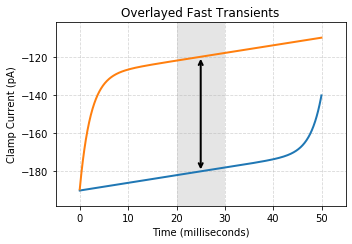

In [10]:
plt.figure(figsize=(5, 3.5))
plt.grid(ls='--', alpha=.5)
plt.plot(overlayedTimes, signalFallingRev, lw=2, label="falling")
plt.plot(overlayedTimes, signalRising, lw=2, label="rising")
plt.axvspan(20, 30, color='k', lw=0, alpha=.1)
plt.annotate(s='',
             xy=(25,meanFalling), 
             xytext=(25,meanRising), 
             arrowprops=dict(arrowstyle='<->', linewidth=2))
#plt.text(25.5, -153, R'$\Delta$I', fontSize = 16, fontName = "Serif")

plt.ylabel("Clamp Current (pA)")
plt.xlabel("Time (milliseconds)")
plt.title("Overlayed Fast Transients")

#plt.legend(loc=4)
plt.margins(.1, .1)
plt.tight_layout()
plt.savefig("mtramp3.png")
plt.show()

In [11]:
# dI = dQ / dt
# dI = Cm * dV / dt
# Cm = dI / (dV/dT)
Cm = (dI/2) / (10e-3 / 50e-3) # 10mV over 50ms
print(f"{Cm*1e12:.03f} pF")

149.993 pF
